In [1]:
%cd /home/Reguformer/notebooks

/home/Reguformer/notebooks


In [2]:
import os
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

warnings.filterwarnings("ignore")

from copy import deepcopy
from trans_oil_gas import utils_fix_seeds, utils_cv

In [3]:
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gpu = [0] if 'cuda' in device.type else 0
print(device, gpu)

cpu 0


In [5]:
utils_fix_seeds.fix_seeds(device=device)

In [6]:
df = pd.read_csv('../data/synthetic_well_log_data.csv')
print(df.shape, df['WELLNAME'].nunique())

(735, 5) 4


In [7]:
# n_trials = 30
# n_splits_res = 5
# n_splits_hpo = 2 
# epochs = 20
n_trials = 2
n_splits_res = 2
n_splits_hpo = 2 
epochs = 2

slice_len = 100
well_column = "WELLNAME"

In [8]:
# results_len_train = 25000
# results_len_test = 5000

results_len_train = 50
results_len_test = 50

In [9]:
save_dir = "./saves_all_models/"
log_dir = "./logs_all_models/"

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

if not os.path.exists(log_dir):
    os.mkdir(log_dir)

In [10]:
def calc_f1_score(precision_nparray, recall_nparray):
    f1_nparray = 2 * (precision_nparray * recall_nparray) / (precision_nparray + recall_nparray)
    f1_str = '{} ± {}'.format(
        round(f1_nparray.mean(), 3), 
        round(f1_nparray.std(), 3)
    )
    return f1_str

In [11]:
def get_dict(res_dict, model_name):
    metrics = dict()

    for d in res_dict:
        f1_flag = False
        for k, v in d.items():
            v = np.array(v)
            v[v == -1000000.0] = np.nan
            if not f1_flag and "Precision" in k:
                precision = deepcopy(v)
                predicate = "" if "_" not in k else k.split("_")[0] + "_"
            if not f1_flag and 'Recall' in k:
                recall = deepcopy(v)
                metrics["{}F1".format(predicate)] = [calc_f1_score(precision, recall)]
                f1_flag = True

            metrics[k] = ['{} ± {}'.format(
                round(v.mean(), 3), 
                round(v.std(), 3)
            )]
    return pd.DataFrame(metrics, index=[model_name]) 

In [12]:
data_kwargs = {
    "df": df,
    "n_splits_hpo": n_splits_hpo,
    "n_splits_res": n_splits_res,
    "epochs": epochs,
    "slice_len": slice_len,
    "results_len_train": results_len_train,
    "results_len_test": results_len_test,
    "well_column": well_column,
    "save_dir": save_dir,
    "log_dir": log_dir,
}

In [13]:
shared_fixed_params = {
    "enc_in": 4,
    "distil": None,
    "device": device,
    "attn": "prob",
    "activation": "gelu",
    "output_attention": False,
    "n_seq": 100,
}
fixed_params_reguformer = {
    "attn": "prob",
    "activation": "gelu",
}
fixed_params_tr = {
    "attn": "full",
    "activation": "relu",
}

default_params_reguformer = {
    "d_model": 64,
} 
specific_params_reguformer = {
    "d_model": ("cat", [16, 32, 64]),
    "factor": ("int", [3, 11, 2]),
    "n_heads": ("cat", [2, 4, 6, 8]),
    "dropout": ("float", [0.1, 0.5]),
    "d_ff" : ("cat", [128, 512, 1024]),
    "e_layers": ("int", [2, 6, 1]),
}

# Reguformers

In [14]:
ans_df = pd.DataFrame()
fixed_params = deepcopy(shared_fixed_params)
fixed_params.update(fixed_params_reguformer)

for loss_type in ["siamese", "triplet"]: 
    for sparse_type in [
        "topQ", "randQ", 
        "topK", "randK", 
        "topQ_topK", "topQ_randK", 
        "randQ_topK", "randQ_randK",
    ]: 
        default_params_reguformer["sparsification_type"] = sparse_type
        specific_params_reguformer["sparsification_type"] = ("cat", [sparse_type])

        res_model, results, roc_auc_all_trials = utils_cv.optuna_hpo_and_best_model_evaluation(
            model_type="{}_reguformer_{}".format(loss_type, sparse_type),
            device=device,
            gpu=gpu,
            n_trials=n_trials,
            fixed_params=fixed_params,
            default_params=default_params_reguformer,
            specific_params=specific_params_reguformer,
            data_kwargs=data_kwargs,
        )
        np.save(
            os.path.join(data_kwargs["save_dir"], "roc_auc_{}_reguformer_{}.npy".format(loss_type, sparse_type)),
            roc_auc_all_trials,
        )
        torch.save(
            res_model.state_dict(), 
            os.path.join(
                data_kwargs["save_dir"], 'res_{}_reguformer_{}.pth'.format(loss_type, sparse_type)
            ),
        )
        ans_df = ans_df.append(get_dict(results, default_params_reguformer["sparsification_type"]))
        
    ans_df.to_csv(
        os.path.join(
            data_kwargs["save_dir"], "res_df_{}_reguformers.csv".format(loss_type)
        )
    )

[I 2023-11-02 17:30:19,147] A new study created in memory with name: no-name-d0747c46-baad-4e85-9272-2dc22e1d670a
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 84.5 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
84.5 K    Trainable params
0         Non-trainable params
84.5 K    Total params
0.338     Total estimated model params size (MB)


model_type: siamese_reguformer_topQ


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 84.5 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
84.5 K    Trainable params
0         Non-trainable params
84.5 K    Total params
0.338     Total estimated model params size (MB)


Accuracy:0.6, ROC_AUC:0.592, PR_AUC:0.566


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:30:25,058] Trial 0 finished with value: 0.7494000000000001 and parameters: {'d_model': 64, 'factor': 11, 'n_heads': 2, 'dropout': 0.18613236209295395, 'd_ff': 128, 'e_layers': 2, 'sparsification_type': 'topQ'}. Best is trial 0 with value: 0.7494000000000001.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 86.1 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
86.1 K    Trainable params
0         Non-trainable params
86.1 K    Total params
0.345     Total estimated model params size (MB)


Accuracy:0.81, ROC_AUC:0.907, PR_AUC:0.907


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 86.1 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
86.1 K    Trainable params
0         Non-trainable params
86.1 K    Total params
0.345     Total estimated model params size (MB)


Accuracy:0.6, ROC_AUC:0.652, PR_AUC:0.636


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:30:34,315] Trial 1 finished with value: 0.7664 and parameters: {'d_model': 32, 'factor': 5, 'n_heads': 8, 'dropout': 0.23609687153834816, 'd_ff': 128, 'e_layers': 6, 'sparsification_type': 'topQ'}. Best is trial 1 with value: 0.7664.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 86.1 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
86.1 K    Trainable params
0         Non-trainable params
86.1 K    Total params
0.345     Total estimated model params size (MB)


Accuracy:0.8, ROC_AUC:0.88, PR_AUC:0.875
best_params: {'d_model': 32, 'factor': 5, 'n_heads': 8, 'dropout': 0.23609687153834816, 'd_ff': 128, 'e_layers': 6, 'sparsification_type': 'topQ'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 86.1 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
86.1 K    Trainable params
0         Non-trainable params
86.1 K    Total params
0.345     Total estimated model params size (MB)


Accuracy:0.5, ROC_AUC:0.782, PR_AUC:0.845
TN: 0, FP: 25, FN: 0, TP: 25
precision = tp / (tp + fp); recall = tp / (tp + fn)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:30:41,738] A new study created in memory with name: no-name-774a2fc9-aa52-42f3-968c-0b12a83645d4
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 349 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K     Total params
1.399     Total estimated model params size (MB)


Accuracy:0.58, ROC_AUC:0.968, PR_AUC:0.964
TN: 4, FP: 21, FN: 0, TP: 25
precision = tp / (tp + fp); recall = tp / (tp + fn)
Accuracy: 0.540 ± 0.040
Precision: 0.522 ± 0.022
Recall: 1.000 ± 0.000
ROC AUC: 0.875 ± 0.093
PR AUC: 0.905 ± 0.059
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: 1.000 ± 0.000
Eucl_Recall: 0.300 ± 0.100
Eucl_ROC AUC: 0.650 ± 0.050
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.686 ± 0.176
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.720 ± 0.200
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [0.5, 0.58], 'Precision': [0.5, 0.5434782608695652], 'Recall': [1.0, 1.0], 'ROC AUC': [0.7824, 0.968], 'PR AUC': [0.8453019087828266, 0.9642844197082588]}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [1.0, 1.0], 'Eucl_Recall': [0.2, 0.4], 'Eucl_ROC AUC': [0.6, 0.7], 'Eucl_PR AUC': [1.0, 1.0]}, {'C

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 349 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K     Total params
1.399     Total estimated model params size (MB)


Accuracy:0.65, ROC_AUC:0.733, PR_AUC:0.729


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:30:49,988] Trial 0 finished with value: 0.8360000000000001 and parameters: {'d_model': 64, 'factor': 11, 'n_heads': 4, 'dropout': 0.27731081981221994, 'd_ff': 512, 'e_layers': 4, 'sparsification_type': 'randQ'}. Best is trial 0 with value: 0.8360000000000001.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 432 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
432 K     Trainable params
0         Non-trainable params
432 K     Total params
1.731     Total estimated model params size (MB)


Accuracy:0.81, ROC_AUC:0.939, PR_AUC:0.94


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 432 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
432 K     Trainable params
0         Non-trainable params
432 K     Total params
1.731     Total estimated model params size (MB)


Accuracy:0.56, ROC_AUC:0.578, PR_AUC:0.567


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:30:59,100] Trial 1 finished with value: 0.6125999999999999 and parameters: {'d_model': 64, 'factor': 3, 'n_heads': 4, 'dropout': 0.4451870914699986, 'd_ff': 512, 'e_layers': 5, 'sparsification_type': 'randQ'}. Best is trial 0 with value: 0.8360000000000001.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 349 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K     Total params
1.399     Total estimated model params size (MB)


Accuracy:0.6, ROC_AUC:0.647, PR_AUC:0.615
best_params: {'d_model': 64, 'factor': 11, 'n_heads': 4, 'dropout': 0.27731081981221994, 'd_ff': 512, 'e_layers': 4, 'sparsification_type': 'randQ'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 349 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K     Total params
1.399     Total estimated model params size (MB)


Accuracy:0.5, ROC_AUC:0.59, PR_AUC:0.566
TN: 20, FP: 5, FN: 20, TP: 5
precision = tp / (tp + fp); recall = tp / (tp + fn)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:31:05,958] A new study created in memory with name: no-name-53a9d9fd-29ea-4fbf-821c-4b7b29bbbfbf
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 84.5 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
84.5 K    Trainable params
0         Non-trainable params
84.5 K    Total params
0.338     Total estimated model params size (MB)


Accuracy:0.7, ROC_AUC:0.773, PR_AUC:0.759
TN: 23, FP: 2, FN: 13, TP: 12
precision = tp / (tp + fp); recall = tp / (tp + fn)
Accuracy: 0.600 ± 0.100
Precision: 0.679 ± 0.179
Recall: 0.340 ± 0.140
ROC AUC: 0.682 ± 0.091
PR AUC: 0.662 ± 0.097
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: nan ± nan
Eucl_Recall: 0.000 ± 0.000
Eucl_ROC AUC: 0.500 ± 0.000
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.750 ± 0.250
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.750 ± 0.250
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [0.5, 0.7], 'Precision': [0.5, 0.8571428571428571], 'Recall': [0.2, 0.48], 'ROC AUC': [0.5904, 0.7728], 'PR AUC': [0.565504227110098, 0.7590330489814333]}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [nan, nan], 'Eucl_Recall': [0.0, 0.0], 'Eucl_ROC AUC': [0.5, 0.5], 'Eucl_PR AUC': [1.0, 1.0]}, {'Cos_A

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 84.5 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
84.5 K    Trainable params
0         Non-trainable params
84.5 K    Total params
0.338     Total estimated model params size (MB)


Accuracy:0.74, ROC_AUC:0.82, PR_AUC:0.827


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:31:11,616] Trial 0 finished with value: 0.8557999999999999 and parameters: {'d_model': 64, 'factor': 9, 'n_heads': 2, 'dropout': 0.3108427263872945, 'd_ff': 128, 'e_layers': 2, 'sparsification_type': 'topK'}. Best is trial 0 with value: 0.8557999999999999.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 435 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
435 K     Trainable params
0         Non-trainable params
435 K     Total params
1.742     Total estimated model params size (MB)


Accuracy:0.8, ROC_AUC:0.892, PR_AUC:0.9


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 435 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
435 K     Trainable params
0         Non-trainable params
435 K     Total params
1.742     Total estimated model params size (MB)


Accuracy:0.73, ROC_AUC:0.755, PR_AUC:0.699


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:31:27,338] Trial 1 finished with value: 0.8216 and parameters: {'d_model': 32, 'factor': 5, 'n_heads': 4, 'dropout': 0.25801430785280083, 'd_ff': 1024, 'e_layers': 6, 'sparsification_type': 'topK'}. Best is trial 0 with value: 0.8557999999999999.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 84.5 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
84.5 K    Trainable params
0         Non-trainable params
84.5 K    Total params
0.338     Total estimated model params size (MB)


Accuracy:0.79, ROC_AUC:0.888, PR_AUC:0.883
best_params: {'d_model': 64, 'factor': 9, 'n_heads': 2, 'dropout': 0.3108427263872945, 'd_ff': 128, 'e_layers': 2, 'sparsification_type': 'topK'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 84.5 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
84.5 K    Trainable params
0         Non-trainable params
84.5 K    Total params
0.338     Total estimated model params size (MB)


Accuracy:0.5, ROC_AUC:0.52, PR_AUC:0.5
TN: 0, FP: 25, FN: 0, TP: 25
precision = tp / (tp + fp); recall = tp / (tp + fn)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:31:34,127] A new study created in memory with name: no-name-4870187f-eb7d-47cf-977a-0f160d643005
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 762 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.052     Total estimated model params size (MB)


Accuracy:0.54, ROC_AUC:0.77, PR_AUC:0.761
TN: 2, FP: 23, FN: 0, TP: 25
precision = tp / (tp + fp); recall = tp / (tp + fn)
Accuracy: 0.520 ± 0.020
Precision: 0.510 ± 0.010
Recall: 1.000 ± 0.000
ROC AUC: 0.645 ± 0.125
PR AUC: 0.630 ± 0.131
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: nan ± nan
Eucl_Recall: 0.000 ± 0.000
Eucl_ROC AUC: 0.500 ± 0.000
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.500 ± 0.000
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.500 ± 0.000
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [0.5, 0.54], 'Precision': [0.5, 0.5208333333333334], 'Recall': [1.0, 1.0], 'ROC AUC': [0.52, 0.7696], 'PR AUC': [0.49953753289651687, 0.7614289035228164]}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [nan, nan], 'Eucl_Recall': [0.0, 0.0], 'Eucl_ROC AUC': [0.5, 0.5], 'Eucl_PR AUC': [1.0, 1.0]}, {'Cos_Ac

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 762 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.052     Total estimated model params size (MB)


Accuracy:0.54, ROC_AUC:0.583, PR_AUC:0.627


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:31:49,062] Trial 0 finished with value: 0.772 and parameters: {'d_model': 64, 'factor': 11, 'n_heads': 8, 'dropout': 0.28331541612900235, 'd_ff': 1024, 'e_layers': 5, 'sparsification_type': 'randK'}. Best is trial 0 with value: 0.772.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 363 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
363 K     Trainable params
0         Non-trainable params
363 K     Total params
1.453     Total estimated model params size (MB)


Accuracy:0.86, ROC_AUC:0.961, PR_AUC:0.964


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 363 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
363 K     Trainable params
0         Non-trainable params
363 K     Total params
1.453     Total estimated model params size (MB)


Accuracy:0.73, ROC_AUC:0.859, PR_AUC:0.851


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:32:01,546] Trial 1 finished with value: 0.9254 and parameters: {'d_model': 32, 'factor': 5, 'n_heads': 6, 'dropout': 0.16698321146777664, 'd_ff': 1024, 'e_layers': 5, 'sparsification_type': 'randK'}. Best is trial 1 with value: 0.9254.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 363 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
363 K     Trainable params
0         Non-trainable params
363 K     Total params
1.453     Total estimated model params size (MB)


Accuracy:0.91, ROC_AUC:0.992, PR_AUC:0.992
best_params: {'d_model': 32, 'factor': 5, 'n_heads': 6, 'dropout': 0.16698321146777664, 'd_ff': 1024, 'e_layers': 5, 'sparsification_type': 'randK'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 363 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
363 K     Trainable params
0         Non-trainable params
363 K     Total params
1.453     Total estimated model params size (MB)


Accuracy:0.66, ROC_AUC:0.965, PR_AUC:0.97
TN: 8, FP: 17, FN: 0, TP: 25
precision = tp / (tp + fp); recall = tp / (tp + fn)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:32:11,927] A new study created in memory with name: no-name-7be5be9a-2b99-444c-a971-9dae7066c6ba
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 181 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
181 K     Trainable params
0         Non-trainable params
181 K     Total params
0.726     Total estimated model params size (MB)


Accuracy:0.76, ROC_AUC:1.0, PR_AUC:1.0
TN: 13, FP: 12, FN: 0, TP: 25
precision = tp / (tp + fp); recall = tp / (tp + fn)
Accuracy: 0.710 ± 0.050
Precision: 0.635 ± 0.040
Recall: 1.000 ± 0.000
ROC AUC: 0.982 ± 0.018
PR AUC: 0.985 ± 0.015
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: 1.000 ± 0.000
Eucl_Recall: 0.360 ± 0.120
Eucl_ROC AUC: 0.680 ± 0.060
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 1.000 ± 0.000
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 1.000 ± 0.000
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [0.66, 0.76], 'Precision': [0.5952380952380952, 0.6756756756756757], 'Recall': [1.0, 1.0], 'ROC AUC': [0.9648, 1.0], 'PR AUC': [0.96971743248364, 1.0]}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [1.0, 1.0], 'Eucl_Recall': [0.24, 0.48], 'Eucl_ROC AUC': [0.62, 0.74], 'Eucl_PR AUC': [1.0, 1.0]}, {'Cos

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 181 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
181 K     Trainable params
0         Non-trainable params
181 K     Total params
0.726     Total estimated model params size (MB)


Accuracy:0.67, ROC_AUC:0.728, PR_AUC:0.743


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:32:20,384] Trial 0 finished with value: 0.7544 and parameters: {'d_model': 64, 'factor': 5, 'n_heads': 6, 'dropout': 0.27539061998425535, 'd_ff': 512, 'e_layers': 2, 'sparsification_type': 'topQ_topK'}. Best is trial 0 with value: 0.7544.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 364 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
364 K     Trainable params
0         Non-trainable params
364 K     Total params
1.459     Total estimated model params size (MB)


Accuracy:0.69, ROC_AUC:0.78, PR_AUC:0.726


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 364 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
364 K     Trainable params
0         Non-trainable params
364 K     Total params
1.459     Total estimated model params size (MB)


Accuracy:0.42, ROC_AUC:0.415, PR_AUC:0.516


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:32:34,629] Trial 1 finished with value: 0.5 and parameters: {'d_model': 32, 'factor': 9, 'n_heads': 2, 'dropout': 0.45269574891036146, 'd_ff': 1024, 'e_layers': 5, 'sparsification_type': 'topQ_topK'}. Best is trial 0 with value: 0.7544.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 181 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
181 K     Trainable params
0         Non-trainable params
181 K     Total params
0.726     Total estimated model params size (MB)


Accuracy:0.58, ROC_AUC:0.585, PR_AUC:0.578
best_params: {'d_model': 64, 'factor': 5, 'n_heads': 6, 'dropout': 0.27539061998425535, 'd_ff': 512, 'e_layers': 2, 'sparsification_type': 'topQ_topK'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 181 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
181 K     Trainable params
0         Non-trainable params
181 K     Total params
0.726     Total estimated model params size (MB)


Accuracy:0.64, ROC_AUC:0.662, PR_AUC:0.623
TN: 12, FP: 13, FN: 5, TP: 20
precision = tp / (tp + fp); recall = tp / (tp + fn)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:32:42,464] A new study created in memory with name: no-name-7ce51a40-bfe9-4174-aec2-570d2c7e4420
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 84.5 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
84.5 K    Trainable params
0         Non-trainable params
84.5 K    Total params
0.338     Total estimated model params size (MB)


Accuracy:0.64, ROC_AUC:0.742, PR_AUC:0.776
TN: 11, FP: 14, FN: 4, TP: 21
precision = tp / (tp + fp); recall = tp / (tp + fn)
Accuracy: 0.640 ± 0.000
Precision: 0.603 ± 0.003
Recall: 0.820 ± 0.020
ROC AUC: 0.702 ± 0.040
PR AUC: 0.699 ± 0.076
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: nan ± nan
Eucl_Recall: 0.000 ± 0.000
Eucl_ROC AUC: 0.500 ± 0.000
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.735 ± 0.191
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.770 ± 0.190
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [0.64, 0.64], 'Precision': [0.6060606060606061, 0.6], 'Recall': [0.8, 0.84], 'ROC AUC': [0.6624, 0.7424], 'PR AUC': [0.6229570259045817, 0.7758408970789588]}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [nan, nan], 'Eucl_Recall': [0.0, 0.0], 'Eucl_ROC AUC': [0.5, 0.5], 'Eucl_PR AUC': [1.0, 1.0]}, {'C

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 84.5 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
84.5 K    Trainable params
0         Non-trainable params
84.5 K    Total params
0.338     Total estimated model params size (MB)


Accuracy:0.52, ROC_AUC:0.589, PR_AUC:0.595


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:32:49,365] Trial 0 finished with value: 0.6892 and parameters: {'d_model': 64, 'factor': 9, 'n_heads': 2, 'dropout': 0.4054086760248309, 'd_ff': 128, 'e_layers': 2, 'sparsification_type': 'topQ_randK'}. Best is trial 0 with value: 0.6892.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 151 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.607     Total estimated model params size (MB)


Accuracy:0.71, ROC_AUC:0.79, PR_AUC:0.797


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 151 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.607     Total estimated model params size (MB)


Accuracy:0.55, ROC_AUC:0.533, PR_AUC:0.485


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:32:58,078] Trial 1 finished with value: 0.5926 and parameters: {'d_model': 32, 'factor': 5, 'n_heads': 8, 'dropout': 0.1535313221618483, 'd_ff': 1024, 'e_layers': 2, 'sparsification_type': 'topQ_randK'}. Best is trial 0 with value: 0.6892.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 84.5 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
84.5 K    Trainable params
0         Non-trainable params
84.5 K    Total params
0.338     Total estimated model params size (MB)


Accuracy:0.64, ROC_AUC:0.652, PR_AUC:0.559
best_params: {'d_model': 64, 'factor': 9, 'n_heads': 2, 'dropout': 0.4054086760248309, 'd_ff': 128, 'e_layers': 2, 'sparsification_type': 'topQ_randK'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 84.5 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
84.5 K    Trainable params
0         Non-trainable params
84.5 K    Total params
0.338     Total estimated model params size (MB)


Accuracy:0.56, ROC_AUC:0.538, PR_AUC:0.54
TN: 14, FP: 11, FN: 11, TP: 14
precision = tp / (tp + fp); recall = tp / (tp + fn)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:33:04,943] A new study created in memory with name: no-name-efb52fd3-bf4a-4d7e-b1d4-be03e0bf8f81


Accuracy:0.62, ROC_AUC:0.65, PR_AUC:0.652
TN: 13, FP: 12, FN: 7, TP: 18
precision = tp / (tp + fp); recall = tp / (tp + fn)
Accuracy: 0.590 ± 0.030
Precision: 0.580 ± 0.020
Recall: 0.640 ± 0.080
ROC AUC: 0.594 ± 0.056
PR AUC: 0.596 ± 0.056
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: nan ± nan
Eucl_Recall: 0.000 ± 0.000
Eucl_ROC AUC: 0.500 ± 0.000
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.500 ± 0.000
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.500 ± 0.000
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [0.56, 0.62], 'Precision': [0.56, 0.6], 'Recall': [0.56, 0.72], 'ROC AUC': [0.5376, 0.6496], 'PR AUC': [0.5403824993887562, 0.6520437289569365]}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [nan, nan], 'Eucl_Recall': [0.0, 0.0], 'Eucl_ROC AUC': [0.5, 0.5], 'Eucl_PR AUC': [1.0, 1.0]}, {'Cos_Accuracy': 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 212 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
212 K     Trainable params
0         Non-trainable params
212 K     Total params
0.849     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 212 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
212 K     Trainable params
0         Non-trainable params
212 K     Total params
0.849     Total estimated model params size (MB)


Accuracy:0.56, ROC_AUC:0.562, PR_AUC:0.532


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:33:14,301] Trial 0 finished with value: 0.551 and parameters: {'d_model': 64, 'factor': 3, 'n_heads': 6, 'dropout': 0.4770000487824789, 'd_ff': 128, 'e_layers': 6, 'sparsification_type': 'randQ_topK'}. Best is trial 0 with value: 0.551.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 184 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.740     Total estimated model params size (MB)


Accuracy:0.54, ROC_AUC:0.54, PR_AUC:0.54


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 184 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.740     Total estimated model params size (MB)


Accuracy:0.51, ROC_AUC:0.534, PR_AUC:0.595


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:33:23,076] Trial 1 finished with value: 0.6910000000000001 and parameters: {'d_model': 64, 'factor': 3, 'n_heads': 8, 'dropout': 0.2110314809096664, 'd_ff': 128, 'e_layers': 5, 'sparsification_type': 'randQ_topK'}. Best is trial 1 with value: 0.6910000000000001.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 184 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.740     Total estimated model params size (MB)


Accuracy:0.77, ROC_AUC:0.848, PR_AUC:0.88
best_params: {'d_model': 64, 'factor': 3, 'n_heads': 8, 'dropout': 0.2110314809096664, 'd_ff': 128, 'e_layers': 5, 'sparsification_type': 'randQ_topK'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 184 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.740     Total estimated model params size (MB)


Accuracy:0.52, ROC_AUC:0.587, PR_AUC:0.551
TN: 16, FP: 9, FN: 15, TP: 10
precision = tp / (tp + fp); recall = tp / (tp + fn)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:33:31,242] A new study created in memory with name: no-name-4c06d8fd-aec7-464f-8a7f-22d911fcc11e
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 911 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
911 K     Trainable params
0         Non-trainable params
911 K     Total params
3.648     Total estimated model params size (MB)


Accuracy:0.64, ROC_AUC:0.749, PR_AUC:0.777
TN: 23, FP: 2, FN: 16, TP: 9
precision = tp / (tp + fp); recall = tp / (tp + fn)
Accuracy: 0.580 ± 0.060
Precision: 0.672 ± 0.146
Recall: 0.380 ± 0.020
ROC AUC: 0.668 ± 0.081
PR AUC: 0.664 ± 0.113
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: nan ± nan
Eucl_Recall: 0.000 ± 0.000
Eucl_ROC AUC: 0.500 ± 0.000
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.713 ± 0.213
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.730 ± 0.230
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [0.52, 0.64], 'Precision': [0.5263157894736842, 0.8181818181818182], 'Recall': [0.4, 0.36], 'ROC AUC': [0.5871999999999999, 0.7488], 'PR AUC': [0.5505433662798318, 0.7770393434511802]}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [nan, nan], 'Eucl_Recall': [0.0, 0.0], 'Eucl_ROC AUC': [0.5, 0.5], 'Eucl

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 911 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
911 K     Trainable params
0         Non-trainable params
911 K     Total params
3.648     Total estimated model params size (MB)


Accuracy:0.53, ROC_AUC:0.553, PR_AUC:0.595


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:33:46,504] Trial 0 finished with value: 0.6581999999999999 and parameters: {'d_model': 64, 'factor': 7, 'n_heads': 2, 'dropout': 0.46929937706767944, 'd_ff': 1024, 'e_layers': 6, 'sparsification_type': 'randQ_randK'}. Best is trial 0 with value: 0.6581999999999999.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 160 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.642     Total estimated model params size (MB)


Accuracy:0.69, ROC_AUC:0.764, PR_AUC:0.739


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 160 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.642     Total estimated model params size (MB)


Accuracy:0.52, ROC_AUC:0.618, PR_AUC:0.598


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:33:54,475] Trial 1 finished with value: 0.7386 and parameters: {'d_model': 32, 'factor': 3, 'n_heads': 2, 'dropout': 0.18997335543108662, 'd_ff': 512, 'e_layers': 4, 'sparsification_type': 'randQ_randK'}. Best is trial 1 with value: 0.7386.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 160 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.642     Total estimated model params size (MB)


Accuracy:0.69, ROC_AUC:0.86, PR_AUC:0.87
best_params: {'d_model': 32, 'factor': 3, 'n_heads': 2, 'dropout': 0.18997335543108662, 'd_ff': 512, 'e_layers': 4, 'sparsification_type': 'randQ_randK'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 160 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.642     Total estimated model params size (MB)


Accuracy:0.5, ROC_AUC:0.634, PR_AUC:0.637
TN: 22, FP: 3, FN: 22, TP: 3
precision = tp / (tp + fp); recall = tp / (tp + fn)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:34:01,973] A new study created in memory with name: no-name-471272e6-6ed8-4a64-9c30-5263baf1835e
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 420 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
420 K     Trainable params
0         Non-trainable params
420 K     Total params
1.681     Total estimated model params size (MB)


Accuracy:0.56, ROC_AUC:0.786, PR_AUC:0.758
TN: 23, FP: 2, FN: 20, TP: 5
precision = tp / (tp + fp); recall = tp / (tp + fn)
Accuracy: 0.530 ± 0.030
Precision: 0.607 ± 0.107
Recall: 0.160 ± 0.040
ROC AUC: 0.710 ± 0.076
PR AUC: 0.698 ± 0.061
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: 1.000 ± 0.000
Eucl_Recall: 0.340 ± 0.180
Eucl_ROC AUC: 0.670 ± 0.090
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.713 ± 0.213
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.730 ± 0.230
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [0.5, 0.56], 'Precision': [0.5, 0.7142857142857143], 'Recall': [0.12, 0.2], 'ROC AUC': [0.6335999999999999, 0.7856000000000001], 'PR AUC': [0.6371771505422403, 0.758414007888895]}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [1.0, 1.0], 'Eucl_Recall': [0.16, 0.52], 'Eucl_ROC AUC': [0.58, 0.76], 'E

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 420 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
420 K     Trainable params
0         Non-trainable params
420 K     Total params
1.681     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:34:09,781] Trial 0 finished with value: 0.5 and parameters: {'d_model': 64, 'factor': 7, 'n_heads': 2, 'dropout': 0.3780680730001579, 'd_ff': 512, 'e_layers': 5, 'sparsification_type': 'topQ'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 102 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.410     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 102 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.410     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:34:16,166] Trial 1 finished with value: 0.5 and parameters: {'d_model': 64, 'factor': 7, 'n_heads': 6, 'dropout': 0.4007290928121704, 'd_ff': 128, 'e_layers': 3, 'sparsification_type': 'topQ'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 420 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
420 K     Trainable params
0         Non-trainable params
420 K     Total params
1.681     Total estimated model params size (MB)


best_params: {'d_model': 64, 'factor': 7, 'n_heads': 2, 'dropout': 0.3780680730001579, 'd_ff': 512, 'e_layers': 5, 'sparsification_type': 'topQ'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 420 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
420 K     Trainable params
0         Non-trainable params
420 K     Total params
1.681     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:34:25,081] A new study created in memory with name: no-name-b73c3902-19c3-4375-9b43-3f0deaa7e8b4
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 172 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
172 K     Trainable params
0         Non-trainable params
172 K     Total params
0.690     Total estimated model params size (MB)


Accuracy: nan ± nan
Precision: nan ± nan
Recall: nan ± nan
ROC AUC: nan ± nan
PR AUC: nan ± nan
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: nan ± nan
Eucl_Recall: 0.000 ± 0.000
Eucl_ROC AUC: 0.500 ± 0.000
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.500 ± 0.000
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.500 ± 0.000
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [], 'Precision': [], 'Recall': [], 'ROC AUC': [], 'PR AUC': []}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [nan, nan], 'Eucl_Recall': [0.0, 0.0], 'Eucl_ROC AUC': [0.5, 0.5], 'Eucl_PR AUC': [1.0, 1.0]}, {'Cos_Accuracy': [1.0, 1.0], 'Cos_Precision': [0.5, 0.5], 'Cos_Recall': [1.0, 1.0], 'Cos_ROC AUC': [0.5, 0.5], 'Cos_PR AUC': [1.0, 1.0]})
****************************************************************************************************
mod

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 172 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
172 K     Trainable params
0         Non-trainable params
172 K     Total params
0.690     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:34:30,873] Trial 0 finished with value: 0.5 and parameters: {'d_model': 64, 'factor': 5, 'n_heads': 4, 'dropout': 0.11125302538953444, 'd_ff': 128, 'e_layers': 5, 'sparsification_type': 'randQ'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 32.9 K
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
32.9 K    Trainable params
0         Non-trainable params
32.9 K    Total params
0.131     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 32.9 K
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
32.9 K    Trainable params
0         Non-trainable params
32.9 K    Total params
0.131     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:34:36,620] Trial 1 finished with value: 0.5 and parameters: {'d_model': 16, 'factor': 3, 'n_heads': 8, 'dropout': 0.2620892877950212, 'd_ff': 128, 'e_layers': 6, 'sparsification_type': 'randQ'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 172 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
172 K     Trainable params
0         Non-trainable params
172 K     Total params
0.690     Total estimated model params size (MB)


best_params: {'d_model': 64, 'factor': 5, 'n_heads': 4, 'dropout': 0.11125302538953444, 'd_ff': 128, 'e_layers': 5, 'sparsification_type': 'randQ'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 172 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
172 K     Trainable params
0         Non-trainable params
172 K     Total params
0.690     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:34:43,244] A new study created in memory with name: no-name-7121b4df-7736-4df4-8f85-e5268ac59f65
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 893 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
893 K     Trainable params
0         Non-trainable params
893 K     Total params
3.573     Total estimated model params size (MB)


Accuracy: nan ± nan
Precision: nan ± nan
Recall: nan ± nan
ROC AUC: nan ± nan
PR AUC: nan ± nan
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: nan ± nan
Eucl_Recall: 0.020 ± 0.020
Eucl_ROC AUC: 0.510 ± 0.010
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.500 ± 0.000
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.500 ± 0.000
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [], 'Precision': [], 'Recall': [], 'ROC AUC': [], 'PR AUC': []}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [nan, 1.0], 'Eucl_Recall': [0.0, 0.04], 'Eucl_ROC AUC': [0.5, 0.52], 'Eucl_PR AUC': [1.0, 1.0]}, {'Cos_Accuracy': [1.0, 1.0], 'Cos_Precision': [0.5, 0.5], 'Cos_Recall': [1.0, 1.0], 'Cos_ROC AUC': [0.5, 0.5], 'Cos_PR AUC': [1.0, 1.0]})
****************************************************************************************************
m

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 893 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
893 K     Trainable params
0         Non-trainable params
893 K     Total params
3.573     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:34:55,118] Trial 0 finished with value: 0.5 and parameters: {'d_model': 64, 'factor': 5, 'n_heads': 6, 'dropout': 0.11518538670057438, 'd_ff': 1024, 'e_layers': 6, 'sparsification_type': 'topK'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 152 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
152 K     Trainable params
0         Non-trainable params
152 K     Total params
0.609     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 152 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
152 K     Trainable params
0         Non-trainable params
152 K     Total params
0.609     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:35:02,456] Trial 1 finished with value: 0.5 and parameters: {'d_model': 32, 'factor': 9, 'n_heads': 4, 'dropout': 0.35493356729288295, 'd_ff': 512, 'e_layers': 4, 'sparsification_type': 'topK'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 893 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
893 K     Trainable params
0         Non-trainable params
893 K     Total params
3.573     Total estimated model params size (MB)


best_params: {'d_model': 64, 'factor': 5, 'n_heads': 6, 'dropout': 0.11518538670057438, 'd_ff': 1024, 'e_layers': 6, 'sparsification_type': 'topK'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 893 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
893 K     Trainable params
0         Non-trainable params
893 K     Total params
3.573     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:35:15,678] A new study created in memory with name: no-name-e9c185b5-8472-4ad7-942c-b2efe96de620
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 171 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)


Accuracy: nan ± nan
Precision: nan ± nan
Recall: nan ± nan
ROC AUC: nan ± nan
PR AUC: nan ± nan
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: nan ± nan
Eucl_Recall: 0.000 ± 0.000
Eucl_ROC AUC: 0.500 ± 0.000
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.500 ± 0.000
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.500 ± 0.000
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [], 'Precision': [], 'Recall': [], 'ROC AUC': [], 'PR AUC': []}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [nan, nan], 'Eucl_Recall': [0.0, 0.0], 'Eucl_ROC AUC': [0.5, 0.5], 'Eucl_PR AUC': [1.0, 1.0]}, {'Cos_Accuracy': [1.0, 1.0], 'Cos_Precision': [0.5, 0.5], 'Cos_Recall': [1.0, 1.0], 'Cos_ROC AUC': [0.5, 0.5], 'Cos_PR AUC': [1.0, 1.0]})
****************************************************************************************************
mod

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 171 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:35:21,478] Trial 0 finished with value: 0.5 and parameters: {'d_model': 64, 'factor': 11, 'n_heads': 8, 'dropout': 0.3044207863978492, 'd_ff': 512, 'e_layers': 2, 'sparsification_type': 'randK'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 199 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.799     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 199 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.799     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:35:28,266] Trial 1 finished with value: 0.5 and parameters: {'d_model': 64, 'factor': 11, 'n_heads': 6, 'dropout': 0.23218846886903496, 'd_ff': 128, 'e_layers': 6, 'sparsification_type': 'randK'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 171 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)


best_params: {'d_model': 64, 'factor': 11, 'n_heads': 8, 'dropout': 0.3044207863978492, 'd_ff': 512, 'e_layers': 2, 'sparsification_type': 'randK'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 171 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:35:34,714] A new study created in memory with name: no-name-19a7b970-2eb2-4c3c-b8f9-1ed901260eda
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 171 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)


Accuracy: nan ± nan
Precision: nan ± nan
Recall: nan ± nan
ROC AUC: nan ± nan
PR AUC: nan ± nan
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: nan ± nan
Eucl_Recall: 0.000 ± 0.000
Eucl_ROC AUC: 0.500 ± 0.000
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.500 ± 0.000
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.500 ± 0.000
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [], 'Precision': [], 'Recall': [], 'ROC AUC': [], 'PR AUC': []}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [nan, nan], 'Eucl_Recall': [0.0, 0.0], 'Eucl_ROC AUC': [0.5, 0.5], 'Eucl_PR AUC': [1.0, 1.0]}, {'Cos_Accuracy': [1.0, 1.0], 'Cos_Precision': [0.5, 0.5], 'Cos_Recall': [1.0, 1.0], 'Cos_ROC AUC': [0.5, 0.5], 'Cos_PR AUC': [1.0, 1.0]})
****************************************************************************************************
mod

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 171 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:35:40,329] Trial 0 finished with value: 0.5 and parameters: {'d_model': 64, 'factor': 3, 'n_heads': 2, 'dropout': 0.16274774518631846, 'd_ff': 512, 'e_layers': 2, 'sparsification_type': 'topQ_topK'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 105 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.422     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 105 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.422     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:35:47,107] Trial 1 finished with value: 0.5 and parameters: {'d_model': 16, 'factor': 5, 'n_heads': 2, 'dropout': 0.3872929313935136, 'd_ff': 1024, 'e_layers': 3, 'sparsification_type': 'topQ_topK'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 171 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)


best_params: {'d_model': 64, 'factor': 3, 'n_heads': 2, 'dropout': 0.16274774518631846, 'd_ff': 512, 'e_layers': 2, 'sparsification_type': 'topQ_topK'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 171 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:35:53,567] A new study created in memory with name: no-name-29a0b9e2-a3d5-4521-a096-177fbfa8a260
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 171 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)


Accuracy: nan ± nan
Precision: nan ± nan
Recall: nan ± nan
ROC AUC: nan ± nan
PR AUC: nan ± nan
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: 1.000 ± 0.000
Eucl_Recall: 0.060 ± 0.020
Eucl_ROC AUC: 0.530 ± 0.010
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.500 ± 0.000
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.500 ± 0.000
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [], 'Precision': [], 'Recall': [], 'ROC AUC': [], 'PR AUC': []}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [1.0, 1.0], 'Eucl_Recall': [0.04, 0.08], 'Eucl_ROC AUC': [0.52, 0.54], 'Eucl_PR AUC': [1.0, 1.0]}, {'Cos_Accuracy': [1.0, 1.0], 'Cos_Precision': [0.5, 0.5], 'Cos_Recall': [1.0, 1.0], 'Cos_ROC AUC': [0.5, 0.5], 'Cos_PR AUC': [1.0, 1.0]})
************************************************************************************************

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 171 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:35:59,380] Trial 0 finished with value: 0.5 and parameters: {'d_model': 64, 'factor': 7, 'n_heads': 2, 'dropout': 0.4019194566535972, 'd_ff': 512, 'e_layers': 2, 'sparsification_type': 'topQ_randK'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 54.7 K
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
54.7 K    Trainable params
0         Non-trainable params
54.7 K    Total params
0.219     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 54.7 K
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
54.7 K    Trainable params
0         Non-trainable params
54.7 K    Total params
0.219     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:36:05,374] Trial 1 finished with value: 0.5 and parameters: {'d_model': 16, 'factor': 3, 'n_heads': 8, 'dropout': 0.3354191079916846, 'd_ff': 512, 'e_layers': 3, 'sparsification_type': 'topQ_randK'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 171 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)


best_params: {'d_model': 64, 'factor': 7, 'n_heads': 2, 'dropout': 0.4019194566535972, 'd_ff': 512, 'e_layers': 2, 'sparsification_type': 'topQ_randK'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 171 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:36:11,892] A new study created in memory with name: no-name-5839a146-1390-4050-80ca-0134ebb2809c
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 105 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.422     Total estimated model params size (MB)


Accuracy: nan ± nan
Precision: nan ± nan
Recall: nan ± nan
ROC AUC: nan ± nan
PR AUC: nan ± nan
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: nan ± nan
Eucl_Recall: 0.000 ± 0.000
Eucl_ROC AUC: 0.500 ± 0.000
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.500 ± 0.000
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.500 ± 0.000
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [], 'Precision': [], 'Recall': [], 'ROC AUC': [], 'PR AUC': []}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [nan, nan], 'Eucl_Recall': [0.0, 0.0], 'Eucl_ROC AUC': [0.5, 0.5], 'Eucl_PR AUC': [1.0, 1.0]}, {'Cos_Accuracy': [1.0, 1.0], 'Cos_Precision': [0.5, 0.5], 'Cos_Recall': [1.0, 1.0], 'Cos_ROC AUC': [0.5, 0.5], 'Cos_PR AUC': [1.0, 1.0]})
****************************************************************************************************
mod

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 105 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.422     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:36:17,281] Trial 0 finished with value: 0.5 and parameters: {'d_model': 64, 'factor': 3, 'n_heads': 8, 'dropout': 0.14881952926673755, 'd_ff': 128, 'e_layers': 3, 'sparsification_type': 'randQ_topK'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 414 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
414 K     Trainable params
0         Non-trainable params
414 K     Total params
1.660     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 414 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
414 K     Trainable params
0         Non-trainable params
414 K     Total params
1.660     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:36:26,432] Trial 1 finished with value: 0.5 and parameters: {'d_model': 64, 'factor': 9, 'n_heads': 6, 'dropout': 0.3419733149425469, 'd_ff': 512, 'e_layers': 5, 'sparsification_type': 'randQ_topK'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 105 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.422     Total estimated model params size (MB)


best_params: {'d_model': 64, 'factor': 3, 'n_heads': 8, 'dropout': 0.14881952926673755, 'd_ff': 128, 'e_layers': 3, 'sparsification_type': 'randQ_topK'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 105 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.422     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:36:32,615] A new study created in memory with name: no-name-2bb245cf-89a3-49bd-9eb6-117a43a9c0a4
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 899 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
899 K     Trainable params
0         Non-trainable params
899 K     Total params
3.598     Total estimated model params size (MB)


Accuracy: nan ± nan
Precision: nan ± nan
Recall: nan ± nan
ROC AUC: nan ± nan
PR AUC: nan ± nan
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: nan ± nan
Eucl_Recall: 0.000 ± 0.000
Eucl_ROC AUC: 0.500 ± 0.000
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.500 ± 0.000
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.500 ± 0.000
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [], 'Precision': [], 'Recall': [], 'ROC AUC': [], 'PR AUC': []}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [nan, nan], 'Eucl_Recall': [0.0, 0.0], 'Eucl_ROC AUC': [0.5, 0.5], 'Eucl_PR AUC': [1.0, 1.0]}, {'Cos_Accuracy': [1.0, 1.0], 'Cos_Precision': [0.5, 0.5], 'Cos_Recall': [1.0, 1.0], 'Cos_ROC AUC': [0.5, 0.5], 'Cos_PR AUC': [1.0, 1.0]})
****************************************************************************************************
mod

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 899 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
899 K     Trainable params
0         Non-trainable params
899 K     Total params
3.598     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:36:42,734] Trial 0 finished with value: 0.5 and parameters: {'d_model': 64, 'factor': 7, 'n_heads': 2, 'dropout': 0.20716743215903244, 'd_ff': 1024, 'e_layers': 6, 'sparsification_type': 'randQ_randK'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 210 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.841     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 210 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.841     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:36:51,481] Trial 1 finished with value: 0.5 and parameters: {'d_model': 16, 'factor': 3, 'n_heads': 4, 'dropout': 0.24367861754959966, 'd_ff': 1024, 'e_layers': 6, 'sparsification_type': 'randQ_randK'}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 899 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
899 K     Trainable params
0         Non-trainable params
899 K     Total params
3.598     Total estimated model params size (MB)


best_params: {'d_model': 64, 'factor': 7, 'n_heads': 2, 'dropout': 0.20716743215903244, 'd_ff': 1024, 'e_layers': 6, 'sparsification_type': 'randQ_randK'}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 899 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
899 K     Trainable params
0         Non-trainable params
899 K     Total params
3.598     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Accuracy: nan ± nan
Precision: nan ± nan
Recall: nan ± nan
ROC AUC: nan ± nan
PR AUC: nan ± nan
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: nan ± nan
Eucl_Recall: 0.000 ± 0.000
Eucl_ROC AUC: 0.500 ± 0.000
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.500 ± 0.000
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.500 ± 0.000
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [], 'Precision': [], 'Recall': [], 'ROC AUC': [], 'PR AUC': []}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [nan, nan], 'Eucl_Recall': [0.0, 0.0], 'Eucl_ROC AUC': [0.5, 0.5], 'Eucl_PR AUC': [1.0, 1.0]}, {'Cos_Accuracy': [1.0, 1.0], 'Cos_Precision': [0.5, 0.5], 'Cos_Recall': [1.0, 1.0], 'Cos_ROC AUC': [0.5, 0.5], 'Cos_PR AUC': [1.0, 1.0]})
****************************************************************************************************


# Transformers

In [15]:
fixed_params = deepcopy(shared_fixed_params)
fixed_params.update(fixed_params_tr)

In [16]:
ans_df = pd.DataFrame()

for loss_type in ["siamese", "triplet"]: 
    default_params_reguformer["sparsification_type"] = None
    specific_params_reguformer["sparsification_type"] = ("cat", [None])

    res_model, results, roc_auc_all_trials = utils_cv.optuna_hpo_and_best_model_evaluation(
        model_type="{}_reguformer_None".format(loss_type),
        device=device,
        gpu=gpu,
        n_trials=n_trials,
        fixed_params=fixed_params,
        default_params=default_params_reguformer,
        specific_params=specific_params_reguformer,
        data_kwargs=data_kwargs,
    )
    np.save(
        os.path.join(data_kwargs["save_dir"], "roc_auc_{}_transformer.npy".format(loss_type)),
        roc_auc_all_trials,
    )
    torch.save(
        res_model.state_dict(), 
        os.path.join(
            data_kwargs["save_dir"], 'res_{}_transformer.pth'.format(loss_type)
        ),
    )
    ans_df = ans_df.append(get_dict(results, "Transformer"))
    
ans_df.to_csv(
    os.path.join(
        data_kwargs["save_dir"], "res_df_{}_transformers.csv".format(loss_type)
    )
)

[I 2023-11-02 17:37:03,063] A new study created in memory with name: no-name-063cc259-0204-49ef-bdc2-c1161694ae12


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 911 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
911 K     Trainable params
0         Non-trainable params
911 K     Total params
3.648     Total estimated model params size (MB)


model_type: siamese_reguformer_None


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 911 K 
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
911 K     Trainable params
0         Non-trainable params
911 K     Total params
3.648     Total estimated model params size (MB)


Accuracy:0.48, ROC_AUC:0.455, PR_AUC:0.485


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:37:18,908] Trial 0 finished with value: 0.492 and parameters: {'d_model': 64, 'factor': 7, 'n_heads': 4, 'dropout': 0.4593263730927568, 'd_ff': 1024, 'e_layers': 6, 'sparsification_type': None}. Best is trial 0 with value: 0.492.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 43.0 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
43.0 K    Trainable params
0         Non-trainable params
43.0 K    Total params
0.172     Total estimated model params size (MB)


Accuracy:0.51, ROC_AUC:0.529, PR_AUC:0.534


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 43.0 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
43.0 K    Trainable params
0         Non-trainable params
43.0 K    Total params
0.172     Total estimated model params size (MB)


Accuracy:0.52, ROC_AUC:0.607, PR_AUC:0.605


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:37:26,113] Trial 1 finished with value: 0.655 and parameters: {'d_model': 16, 'factor': 5, 'n_heads': 8, 'dropout': 0.26008608343073153, 'd_ff': 512, 'e_layers': 2, 'sparsification_type': None}. Best is trial 1 with value: 0.655.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 43.0 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
43.0 K    Trainable params
0         Non-trainable params
43.0 K    Total params
0.172     Total estimated model params size (MB)


Accuracy:0.61, ROC_AUC:0.703, PR_AUC:0.711
best_params: {'d_model': 16, 'factor': 5, 'n_heads': 8, 'dropout': 0.26008608343073153, 'd_ff': 512, 'e_layers': 2, 'sparsification_type': None}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 43.0 K
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
43.0 K    Trainable params
0         Non-trainable params
43.0 K    Total params
0.172     Total estimated model params size (MB)


Accuracy:0.56, ROC_AUC:0.611, PR_AUC:0.629
TN: 13, FP: 12, FN: 10, TP: 15
precision = tp / (tp + fp); recall = tp / (tp + fn)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:37:33,250] A new study created in memory with name: no-name-439190a7-58d5-4f21-87d1-3b21c090e295
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 452 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
452 K     Trainable params
0         Non-trainable params
452 K     Total params
1.809     Total estimated model params size (MB)


Accuracy:0.58, ROC_AUC:0.568, PR_AUC:0.524
TN: 12, FP: 13, FN: 8, TP: 17
precision = tp / (tp + fp); recall = tp / (tp + fn)
Accuracy: 0.570 ± 0.010
Precision: 0.561 ± 0.006
Recall: 0.640 ± 0.040
ROC AUC: 0.590 ± 0.022
PR AUC: 0.576 ± 0.052
--------------------------------------------------
Eucl_Accuracy: 0.996 ± 0.001
Eucl_Precision: 1.000 ± 0.000
Eucl_Recall: 0.720 ± 0.040
Eucl_ROC AUC: 0.860 ± 0.020
Eucl_PR AUC: 0.996 ± 0.001
--------------------------------------------------
Cos_Accuracy: 0.994 ± 0.006
Cos_Precision: 0.500 ± 0.000
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.500 ± 0.000
Cos_PR AUC: 0.994 ± 0.006
--------------------------------------------------

all_results: ({'Accuracy': [0.56, 0.58], 'Precision': [0.5555555555555556, 0.5666666666666667], 'Recall': [0.6, 0.68], 'ROC AUC': [0.6112, 0.5680000000000001], 'PR AUC': [0.6287003934555453, 0.523888092120367]}, {'Eucl_Accuracy': [0.9957142857142859, 0.9970370370370372], 'Eucl_Precision': [1.0, 1.0], 'Eucl_Recall': [0.76, 0.68

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 452 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
452 K     Trainable params
0         Non-trainable params
452 K     Total params
1.809     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:37:40,609] Trial 0 finished with value: 0.5 and parameters: {'d_model': 64, 'factor': 3, 'n_heads': 2, 'dropout': 0.4669987903955556, 'd_ff': 1024, 'e_layers': 3, 'sparsification_type': None}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 496 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
496 K     Trainable params
0         Non-trainable params
496 K     Total params
1.988     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 496 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
496 K     Trainable params
0         Non-trainable params
496 K     Total params
1.988     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:37:49,323] Trial 1 finished with value: 0.5 and parameters: {'d_model': 64, 'factor': 5, 'n_heads': 6, 'dropout': 0.45084989666357744, 'd_ff': 512, 'e_layers': 6, 'sparsification_type': None}. Best is trial 0 with value: 0.5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 452 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
452 K     Trainable params
0         Non-trainable params
452 K     Total params
1.809     Total estimated model params size (MB)


best_params: {'d_model': 64, 'factor': 3, 'n_heads': 2, 'dropout': 0.4669987903955556, 'd_ff': 1024, 'e_layers': 3, 'sparsification_type': None}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 452 K 
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
452 K     Trainable params
0         Non-trainable params
452 K     Total params
1.809     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Accuracy: nan ± nan
Precision: nan ± nan
Recall: nan ± nan
ROC AUC: nan ± nan
PR AUC: nan ± nan
--------------------------------------------------
Eucl_Accuracy: 1.000 ± 0.000
Eucl_Precision: nan ± nan
Eucl_Recall: 0.000 ± 0.000
Eucl_ROC AUC: 0.500 ± 0.000
Eucl_PR AUC: 1.000 ± 0.000
--------------------------------------------------
Cos_Accuracy: 1.000 ± 0.000
Cos_Precision: 0.500 ± 0.000
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.500 ± 0.000
Cos_PR AUC: 1.000 ± 0.000
--------------------------------------------------

all_results: ({'Accuracy': [], 'Precision': [], 'Recall': [], 'ROC AUC': [], 'PR AUC': []}, {'Eucl_Accuracy': [1.0, 1.0], 'Eucl_Precision': [nan, nan], 'Eucl_Recall': [0.0, 0.0], 'Eucl_ROC AUC': [0.5, 0.5], 'Eucl_PR AUC': [1.0, 1.0]}, {'Cos_Accuracy': [1.0, 1.0], 'Cos_Precision': [0.5, 0.5], 'Cos_Recall': [1.0, 1.0], 'Cos_ROC AUC': [0.5, 0.5], 'Cos_PR AUC': [1.0, 1.0]})
****************************************************************************************************


# Performer

In [14]:
fixed_params_per = {
    "dim": 4,
    "device": device,
    "use_relu_kernel": False,
    "n_seq": 100
}

default_params_per = {} 

specific_params_per = {
    "head_num": ("cat", [2, 4]),
    "dropout": ("float", [0.1, 0.9]),
    "nb_random_features": ("int", [1, 4])
}

In [15]:
ans_df = pd.DataFrame()

for loss_type in ["siamese", "triplet"]:
    res_model, results, roc_auc_all_trials = utils_cv.optuna_hpo_and_best_model_evaluation(
        model_type="{}_performer".format(loss_type),
        device=device,
        gpu=gpu,
        n_trials=n_trials,
        fixed_params=fixed_params_per,
        default_params=default_params_per,
        specific_params=specific_params_per,
        data_kwargs=data_kwargs,
    )
    np.save(
        os.path.join(data_kwargs["save_dir"], "roc_auc_{}_performer.npy".format(loss_type)),
        roc_auc_all_trials,
    )
    torch.save(
        res_model.state_dict(), 
        os.path.join(
            data_kwargs["save_dir"], 'res_{}_performer.pth'.format(loss_type)
        ),
    )
    ans_df = ans_df.append(get_dict(results, "Performer"))
    
ans_df.to_csv(
    os.path.join(
        data_kwargs["save_dir"], "res_df_{}_performers.csv".format(loss_type)
    )
)

[I 2023-11-02 17:46:16,828] A new study created in memory with name: no-name-35bd682d-ff73-46ec-92e9-2d56636c1ee0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 697   
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
697       Trainable params
0         Non-trainable params
697       Total params
0.003     Total estimated model params size (MB)


model_type: siamese_performer


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 697   
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
697       Trainable params
0         Non-trainable params
697       Total params
0.003     Total estimated model params size (MB)


Accuracy:0.43, ROC_AUC:0.428, PR_AUC:0.445


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:46:19,707] Trial 0 finished with value: 0.4589 and parameters: {'head_num': 4, 'dropout': 0.40360448879517197, 'nb_random_features': 3}. Best is trial 0 with value: 0.4589.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 697   
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
697       Trainable params
0         Non-trainable params
697       Total params
0.003     Total estimated model params size (MB)


Accuracy:0.5, ROC_AUC:0.49, PR_AUC:0.501


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 697   
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
697       Trainable params
0         Non-trainable params
697       Total params
0.003     Total estimated model params size (MB)


Accuracy:0.5, ROC_AUC:0.471, PR_AUC:0.48


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:46:22,508] Trial 1 finished with value: 0.4952000000000001 and parameters: {'head_num': 2, 'dropout': 0.19334168964375148, 'nb_random_features': 2}. Best is trial 1 with value: 0.4952000000000001.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 697   
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
697       Trainable params
0         Non-trainable params
697       Total params
0.003     Total estimated model params size (MB)


Accuracy:0.52, ROC_AUC:0.52, PR_AUC:0.51
best_params: {'head_num': 2, 'dropout': 0.19334168964375148, 'nb_random_features': 2}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SiameseArchitecture | 697   
1 | loss_function | BCELoss             | 0     
------------------------------------------------------
697       Trainable params
0         Non-trainable params
697       Total params
0.003     Total estimated model params size (MB)


Accuracy:0.5, ROC_AUC:0.613, PR_AUC:0.607
TN: 0, FP: 25, FN: 0, TP: 25
precision = tp / (tp + fp); recall = tp / (tp + fn)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:46:24,967] A new study created in memory with name: no-name-af6a946c-10a5-4c4f-8b75-f7f01c9c1a01
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 264   
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
264       Trainable params
0         Non-trainable params
264       Total params
0.001     Total estimated model params size (MB)


Accuracy:0.5, ROC_AUC:0.584, PR_AUC:0.601
TN: 0, FP: 25, FN: 0, TP: 25
precision = tp / (tp + fp); recall = tp / (tp + fn)
Accuracy: 0.500 ± 0.000
Precision: 0.500 ± 0.000
Recall: 1.000 ± 0.000
ROC AUC: 0.598 ± 0.014
PR AUC: 0.604 ± 0.003
--------------------------------------------------
Eucl_Accuracy: 0.932 ± 0.068
Eucl_Precision: 0.971 ± 0.029
Eucl_Recall: 0.820 ± 0.180
Eucl_ROC AUC: 0.900 ± 0.100
Eucl_PR AUC: 0.907 ± 0.093
--------------------------------------------------
Cos_Accuracy: 0.934 ± 0.066
Cos_Precision: 0.500 ± 0.000
Cos_Recall: 1.000 ± 0.000
Cos_ROC AUC: 0.500 ± 0.000
Cos_PR AUC: 0.913 ± 0.087
--------------------------------------------------

all_results: ({'Accuracy': [0.5, 0.5], 'Precision': [0.5, 0.5], 'Recall': [1.0, 1.0], 'ROC AUC': [0.6128, 0.584], 'PR AUC': [0.6065949460268732, 0.6012105909776795]}, {'Eucl_Accuracy': [0.8631059894239885, 1.0], 'Eucl_Precision': [0.9411764705882353, 1.0], 'Eucl_Recall': [0.64, 1.0], 'Eucl_ROC AUC': [0.8, 1.0], 'Eucl_PR AUC': [0

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 264   
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
264       Trainable params
0         Non-trainable params
264       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:46:27,070] Trial 0 finished with value: 0.65 and parameters: {'head_num': 4, 'dropout': 0.1249661767747984, 'nb_random_features': 2}. Best is trial 0 with value: 0.65.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 264   
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
264       Trainable params
0         Non-trainable params
264       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 264   
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
264       Trainable params
0         Non-trainable params
264       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2023-11-02 17:46:29,365] Trial 1 finished with value: 0.6699999999999999 and parameters: {'head_num': 4, 'dropout': 0.15511897971877364, 'nb_random_features': 4}. Best is trial 1 with value: 0.6699999999999999.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 264   
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
264       Trainable params
0         Non-trainable params
264       Total params
0.001     Total estimated model params size (MB)


best_params: {'head_num': 4, 'dropout': 0.15511897971877364, 'nb_random_features': 4}


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TripletArchitecture | 264   
1 | loss_function | TripletMarginLoss   | 0     
------------------------------------------------------
264       Trainable params
0         Non-trainable params
264       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Accuracy: nan ± nan
Precision: nan ± nan
Recall: nan ± nan
ROC AUC: nan ± nan
PR AUC: nan ± nan
--------------------------------------------------
Eucl_Accuracy: 0.921 ± 0.056
Eucl_Precision: 0.899 ± 0.042
Eucl_Recall: 0.800 ± 0.160
Eucl_ROC AUC: 0.850 ± 0.050
Eucl_PR AUC: 0.896 ± 0.077
--------------------------------------------------
Cos_Accuracy: 0.868 ± 0.076
Cos_Precision: 0.594 ± 0.001
Cos_Recall: 0.880 ± 0.120
Cos_ROC AUC: 0.640 ± 0.020
Cos_PR AUC: 0.822 ± 0.109
--------------------------------------------------

all_results: ({'Accuracy': [], 'Precision': [], 'Recall': [], 'ROC AUC': [], 'PR AUC': []}, {'Eucl_Accuracy': [0.8650632080519538, 0.9769236882280362], 'Eucl_Precision': [0.9411764705882353, 0.8571428571428571], 'Eucl_Recall': [0.64, 0.96], 'Eucl_ROC AUC': [0.8, 0.9], 'Eucl_PR AUC': [0.8191999999999999, 0.9727999999999999]}, {'Cos_Accuracy': [0.7920949684602872, 0.9431397739441968], 'Cos_Precision': [0.59375, 0.5952380952380952], 'Cos_Recall': [0.76, 1.0], 'Cos_ROC AUC

# Results aggregation

In [16]:
agg_data = []
for loss_type in ["siamese", "triplet"]:
    for model_type in [
        "topQ", "randQ", 
        "topK", "randK", 
        "topQ_topK", "topQ_randK", 
        "randQ_topK", "randQ_randK",
    ]:
        a = np.load(os.path.join(data_kwargs["save_dir"], "roc_auc_{}_reguformer_{}.npy".format(loss_type, model_type)))
        for i, el in enumerate(a):
            agg_data.append(
                {
                    "model_type": loss_type[0].upper() + loss_type[1:],
                    "model_encoder": model_type, 
                    "scores": el,
                }
            )
    
    for model_type in ["transformer", "performer"]:
        a = np.load(os.path.join(data_kwargs["save_dir"], "roc_auc_{}_{}.npy".format(loss_type, model_type)))
        for i, el in enumerate(a):
            agg_data.append(
                {
                    "model_type": loss_type[0].upper() + loss_type[1:],
                    "model_encoder": model_type[0].upper() + model_type[1:],
                    "scores": el,
                }
            )

In [17]:
agg_data_df = pd.DataFrame(agg_data)
agg_data_df["model_encoder"][agg_data_df["model_encoder"] == "Performer"] = "Performer     "

agg_data_df.to_excel(
    os.path.join(data_kwargs["save_dir"], "all_hpo_roc_aucs.xlsx"),
    index=False,
)
agg_data_df

,model_type,model_encoder,scores
0,Siamese,topQ,0.7494
1,Siamese,topQ,0.7664
2,Siamese,randQ,0.8360
3,Siamese,randQ,0.6126
4,Siamese,topK,0.8558
5,Siamese,topK,0.8216
6,Siamese,randK,0.7720
7,Siamese,randK,0.9254
8,Siamese,topQ_topK,0.7544
9,Siamese,topQ_topK,0.5000


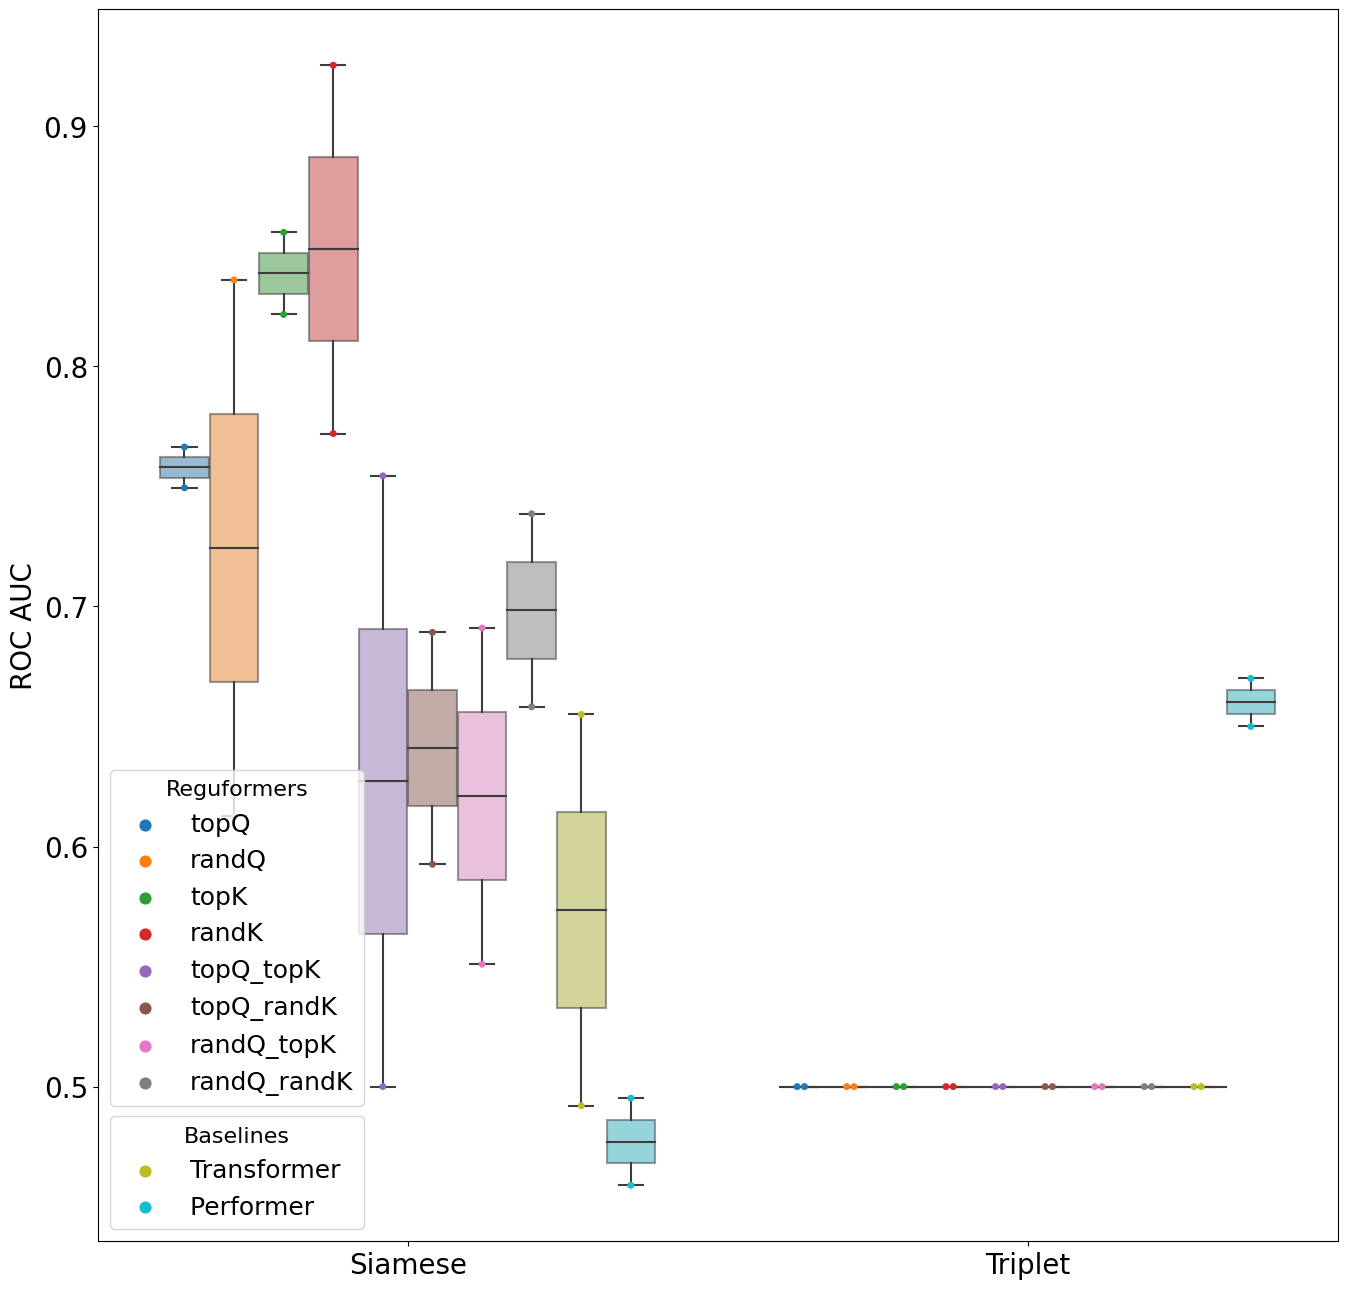

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16));

swarmplot = sns.swarmplot(
    x="model_type", 
    y="scores", 
    data=agg_data_df, 
    hue="model_encoder", 
    dodge=True, 
    ax=ax,
);
boxplot = sns.boxplot(
    x="model_type", 
    y="scores", 
    data=agg_data_df, 
    hue="model_encoder", 
    ax=swarmplot, 
    boxprops={"alpha": 0.5}, 
    showfliers=False,
);

h, l = ax.get_legend_handles_labels()

h,l = ax.get_legend_handles_labels() ##Get the legend handles and lables
l1 = ax.legend(h[10:18], l[10:18], loc="lower left", bbox_to_anchor=(0, 0.1), title="Reguformers", frameon=True) 
l2 = ax.legend(h[18:20], l[18:20], loc="lower left", bbox_to_anchor=(0, 0), title="Baselines", frameon=True)

ax.add_artist(l1)
ax.set_xlabel("");
ax.set_ylabel("ROC AUC");

plt.savefig(
    os.path.join(data_kwargs["save_dir"], 'boxplots_well_linking_all_models.pdf'),
    dpi=500, 
    bbox_inches='tight',
)